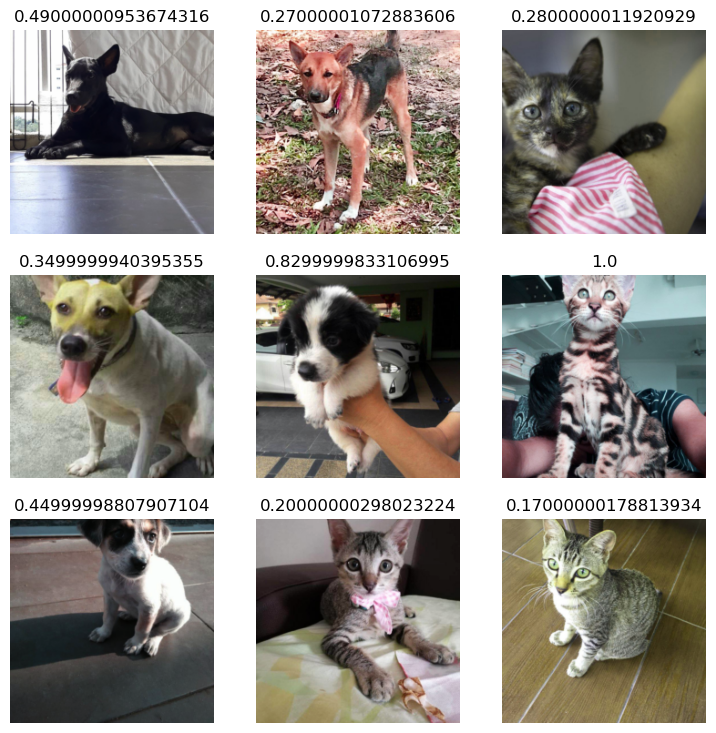

In [14]:
import pandas as pd
import os
import sys
import timm
from timm import create_model
import numpy as np
import torch
from torch import nn
# from torch.utils.data import DataLoaders
from torchvision import datasets
from torchvision.transforms import ToTensor
from fastai.vision.all import *
import gc

img_size = 224
num = 10
batch = 32
seed(228)

img_path = Path('D:/data_semen/DS2022_PAWPULARITY/train') # change if needed

df_train = pd.read_csv("train.csv")

## Left over code from data manipulation/balancing data set. 
# This decreased the number of images which fall in between certain numbers 
# until their count is equal to a set value
#df_train['Pawpularity'].hist(figsize = (10, 5), bins = 100)

# val_thr_lw = 17 #lower score threshold
# val_thr_hg = 55 #upper score threshold
# thr_q = 90 #how many images should be left

# df_train.sort_values(by=["Pawpularity"]) #important otherwise the solution will not work properly

# for i in df_train["Pawpularity"]:
#     quant = df_train["Pawpularity"].value_counts()[i]
#     if ((i <= val_thr_hg) and (i >= val_thr_lw) and (quant > thr_q)) or ((i == 100) and (quant > thr_q)):
#         ind = df_train.index[df_train['Pawpularity'] == i].tolist()

#         for x in range(int(quant - thr_q)):
#             df_train.drop(ind[x], axis = 0, inplace = True)

#df_train['Pawpularity'].hist(figsize = (10, 5), bins = 100)

##

df_train['score_normed'] = df_train['Pawpularity']/100 #normalization
df_train["path"] = df_train["Id"].map(lambda x:str(x)+'.jpg') #add img paths to df
            
df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test_high = df_train[df_train.Pawpularity > 35] #lower score portion of the DF
df_test_high = df_test_high.sample(frac=1).reset_index(drop=True)

df_test_low = df_train[df_train.Pawpularity <= 35]
df_test_low = df_test_low.sample(frac=1).reset_index(drop=True) #higher score portion of the DF
            
dls = ImageDataLoaders.from_df(df_train, valid_pct=0.3, path = img_path, seed = 228, fn_col = 'path', label_col = 'score_normed', 
                               y_block = RegressionBlock, bs = batch, num_workers = 8, item_tfms = Resize(img_size), 
                               batch_tfms = setup_aug_tfms([Flip(), Brightness(), Contrast(), Hue(), Saturation()]))

dls.show_batch()

# predictions = []

In [ ]:
#run this if ypu want to learn optimal learning rate

#model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

#learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()

#learn.lr_find(end_lr=3e-2)

In [8]:
def seed(n): #set random seed
    set_seed(n, reproducible=True)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(torch.sigmoid(input.flatten()), target))

seed(228)

In [ ]:
#Cell for training the networks
train = 0 # set to 1 if you want to train new networks
if train == 1:
    
    # change range if needed
    for i in range(6):# All data networks
        dls = ImageDataLoaders.from_df(df_train, valid_pct=0.3, seed = 228, fn_col = 'path', label_col = 'score_normed', 
                                    y_block = RegressionBlock, bs = 32, num_workers = 8, item_tfms = Resize(224), 
                                batch_tfms = setup_aug_tfms([Flip(), Brightness(), Contrast(), Hue(), Saturation()]))

        model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()
        learn.fit_one_cycle(10, 1e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])

        learn = learn.to_fp32()
        learn.export('swin_tuned_exp{i}' + str(i))

        del learn
        torch.cuda.empty_cache()
        gc.collect()

    # change range if needed
    for i in range(3): #High score network
        dls = ImageDataLoaders.from_df(df_test_high, valid_pct=0.2, seed = 228, fn_col = 'path', label_col = 'score_normed', 
                                y_block = RegressionBlock, bs = 32, num_workers = 8, item_tfms = Resize(224), 
                                batch_tfms = setup_aug_tfms([Flip(), Brightness(), Contrast(), Hue(), Saturation()]))
        
        model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

        learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()
        learn.fit_one_cycle(10, 1e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])
        #learn.recorder.plot_loss()
        #plt.savefig('loss.png')

        learn = learn.to_fp32()
        learn.export('swin_high_exp' + str(i))
        
        del learn

        torch.cuda.empty_cache()

        gc.collect()

    # change range if needed    
    for i in range(3):#Low score network 
        dls = ImageDataLoaders.from_df(df_test_low, valid_pct=0.2, seed = 228, fn_col = 'path', label_col = 'score_normed', 
                                y_block = RegressionBlock, bs = 32, num_workers = 8, item_tfms = Resize(224), 
                                batch_tfms = setup_aug_tfms([Flip(), Brightness(), Contrast(), Hue(), Saturation()]))
        
        model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

        learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()
        learn.fit_one_cycle(10, 1e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])
        #learn.recorder.plot_loss()
        #plt.savefig('loss.png')

        learn = learn.to_fp32()
        learn.export('swin_low_exp' + str(i))
        
        del learn

        torch.cuda.empty_cache()

        gc.collect()

else:
    print("traing disabled")

In [16]:
from matplotlib import pyplot as plt

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

df_test = pd.read_csv('D:/data_semen/DS2022_PAWPULARITY/test.csv')
data_pth = Path('D:/data_semen/DS2022_PAWPULARITY')

df_test["path"] = df_test["Id"].map(lambda x:str(data_pth/'test'/x)+'.jpg')
test_dl = dls.test_dl(df_train)

pt1 = 'D:\data_semen\DS2022_PAWPULARITY\model\swin_tuned_exp' #parh to pretrained models
pt2 = 'D:\data_semen\DS2022_PAWPULARITY\model\swin_high_exp' # change if needed
pt3 = 'D:\data_semen\DS2022_PAWPULARITY\model\swin_low_exp'

pred = []

for i in range(6):# change range if needed
    learn = load_learner((pt1 + str(i)))

    p, _ = learn.tta(dl=test_dl, n=5, beta=0)
    pred.append(p)
    
for i in range(2):# change range if needed
    learn = load_learner((pt2 + str(i)), cpu = False)

    p, _ = learn.tta(dl=test_dl, n=5, beta=0)
    pred.append(p)
    
for i in range(2):# change range if needed
    learn = load_learner((pt3 + str(i)), cpu = False)

    p, _ = learn.tta(dl=test_dl, n=5, beta=0)
    pred.append(p)
    
sub_df = pd.read_csv('D:\data_semen\project\sample_submission.csv')
sub_df['Pawpularity'] = (np.mean(np.hstack(pred), axis=1))*100    
sub_df.to_csv('submission.csv',index=False)

AttributeError: 'GELU' object has no attribute 'approximate'